In [1]:
import sys

sys.path.append("../src/")
from nnet import CRNN
#from pl_trainer import SEDTask4_2021
import pytorch_lightning as pl
from MT_trainer import CoSMo_benchmark
from utils.encoder import ManyHotEncoder
from utils.utils import batched_decode_preds
import scipy
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import torchaudio
import librosa
import librosa.display
import time
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import h5py
import seaborn as sns
from IPython.display import Audio
from processing.sampler import ConcatDatasetBatchSampler
import torch
from tqdm import tqdm
import speechbrain as sb
import os

2025-09-12 15:50:40.275596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-12 15:50:41.727870: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from processing.datasets import ConcatDatasetUrban, HDF5_dataset

In [3]:
with open("../config/sed.yaml", "r") as f: #try to use sed_hear/ sed_bis previous
    conf = yaml.safe_load(f)

In [4]:
with open("../config/sed_fdy.yaml", "r") as f:
    conf_FDY = yaml.safe_load(f)

# Load Encoder

In [5]:
with open(f"../config/taxonomy_SONYC.yaml", "r") as f:
    taxonomy_sn = yaml.safe_load(f)

with open(f"../config/taxonomy_SINGA-PURA.yaml", "r") as f:
    taxonomy_sgp = yaml.safe_load(f)


taxonomy_coarse_sn = taxonomy_sn["coarse"]
taxonomy_fine_sn = taxonomy_sn["fine"]
taxonomy_coarse_sgp = taxonomy_sgp["coarse"]
taxonomy_fine_sgp = taxonomy_sgp["fine"]

encoder_fine_sn = ManyHotEncoder(
    taxonomy_sn,
    use_taxo_fine=True,
    audio_len=conf["data"]["audio_max_len"],
    frame_len=conf["features"]["n_filters"],
    frame_hop=conf["features"]["hop_length"],
    net_pooling=conf["data"]["net_subsample"],
    fs=conf["data"]["fs"],
)
encoder_coarse_sn = ManyHotEncoder(
    taxonomy_sn,
    use_taxo_fine=False,
    audio_len=conf["data"]["audio_max_len"],
    frame_len=conf["features"]["n_filters"],
    frame_hop=conf["features"]["hop_length"],
    net_pooling=conf["data"]["net_subsample"],
    fs=conf["data"]["fs"],
)
encoder_fine_sgp = ManyHotEncoder(
    taxonomy_sgp,
    use_taxo_fine=True,
    audio_len=conf["data"]["audio_max_len"],
    frame_len=conf["features"]["n_filters"],
    frame_hop=conf["features"]["hop_length"],
    net_pooling=conf["data"]["net_subsample"],
    fs=conf["data"]["fs"],
)
encoder_coarse_sgp = ManyHotEncoder(
    taxonomy_sgp,
    use_taxo_fine=False,
    audio_len=conf["data"]["audio_max_len"],
    frame_len=conf["features"]["n_filters"],
    frame_hop=conf["features"]["hop_length"],
    net_pooling=conf["data"]["net_subsample"],
    fs=conf["data"]["fs"],
)
encoder = encoder_coarse_sn

# Load Dataset

## Dataset Prep

In [6]:
SINGAPURA_train_set = HDF5_dataset(
    conf["data"]["root_path"] + conf["data"]["hdf5_train"], "SINGA-PURA", encoder
)
SONYC_train_set = HDF5_dataset(
    conf["data"]["root_path"] + conf["data"]["hdf5_train"], "SONYC", encoder
)
SINGAPURA_val_set = HDF5_dataset(
    conf["data"]["root_path"] + conf["data"]["hdf5_val"], "SINGA-PURA", encoder
)
unlabelled_SINGAPURA_train_set = HDF5_dataset(
    conf["data"]["root_path"] + conf["data"]["hdf5_train"],
    "unlabelled_SINGA-PURA",
    encoder,
)
SONYC_val_set = HDF5_dataset(
    conf["data"]["root_path"] + conf["data"]["hdf5_val"], "SONYC", encoder
)
SINGAPURA_test_set = HDF5_dataset(
    conf["data"]["root_path"] + conf["data"]["hdf5_test"], "SINGA-PURA", encoder
)
SONYC_test_set = HDF5_dataset(
    conf["data"]["root_path"] + conf["data"]["hdf5_test"], "SONYC", encoder
)


## Dataset Concat

In [7]:
batch_sizes = conf["training"]["batch_size"]
batch_sizes = [8, 16, 24]
bs = []
tot_train_data = []
if batch_sizes[0] > 0:
    tot_train_data.append(SINGAPURA_train_set)
    bs.append(batch_sizes[0])
if batch_sizes[1] > 0:
    tot_train_data.append(SONYC_train_set)
    bs.append(batch_sizes[1])
if batch_sizes[2] > 0:
    tot_train_data.append(unlabelled_SINGAPURA_train_set)
    bs.append(batch_sizes[2])


samplers = [torch.utils.data.RandomSampler(x) for x in tot_train_data]
train_dataset = ConcatDatasetUrban(tot_train_data, encoder, batch_sizes=batch_sizes)
if len(bs) > 1:
    batch_sampler = ConcatDatasetBatchSampler(samplers, bs)
else:
    batch_sampler = torch.utils.data.BatchSampler(samplers[0], bs[0], drop_last=True)

valid_dataset = ConcatDatasetUrban(
    [SINGAPURA_val_set, SONYC_val_set], encoder, [conf["training"]["batch_size_val"]]
)

test_dataset = ConcatDatasetUrban(
    [SINGAPURA_test_set, SONYC_test_set], encoder, [conf["training"]["batch_size_val"]]
)

## Show every class count using coarse/fine label

In [8]:
hdf5_path = conf["data"]["root_path"] +  conf["data"]["hdf5_train"]
coarse_encoder = encoder_coarse_sn
fine_encoder = encoder_fine_sn

### show coarse/fine class count in SONYC

已保存图表: sonyc_event_distribution_subplots.png


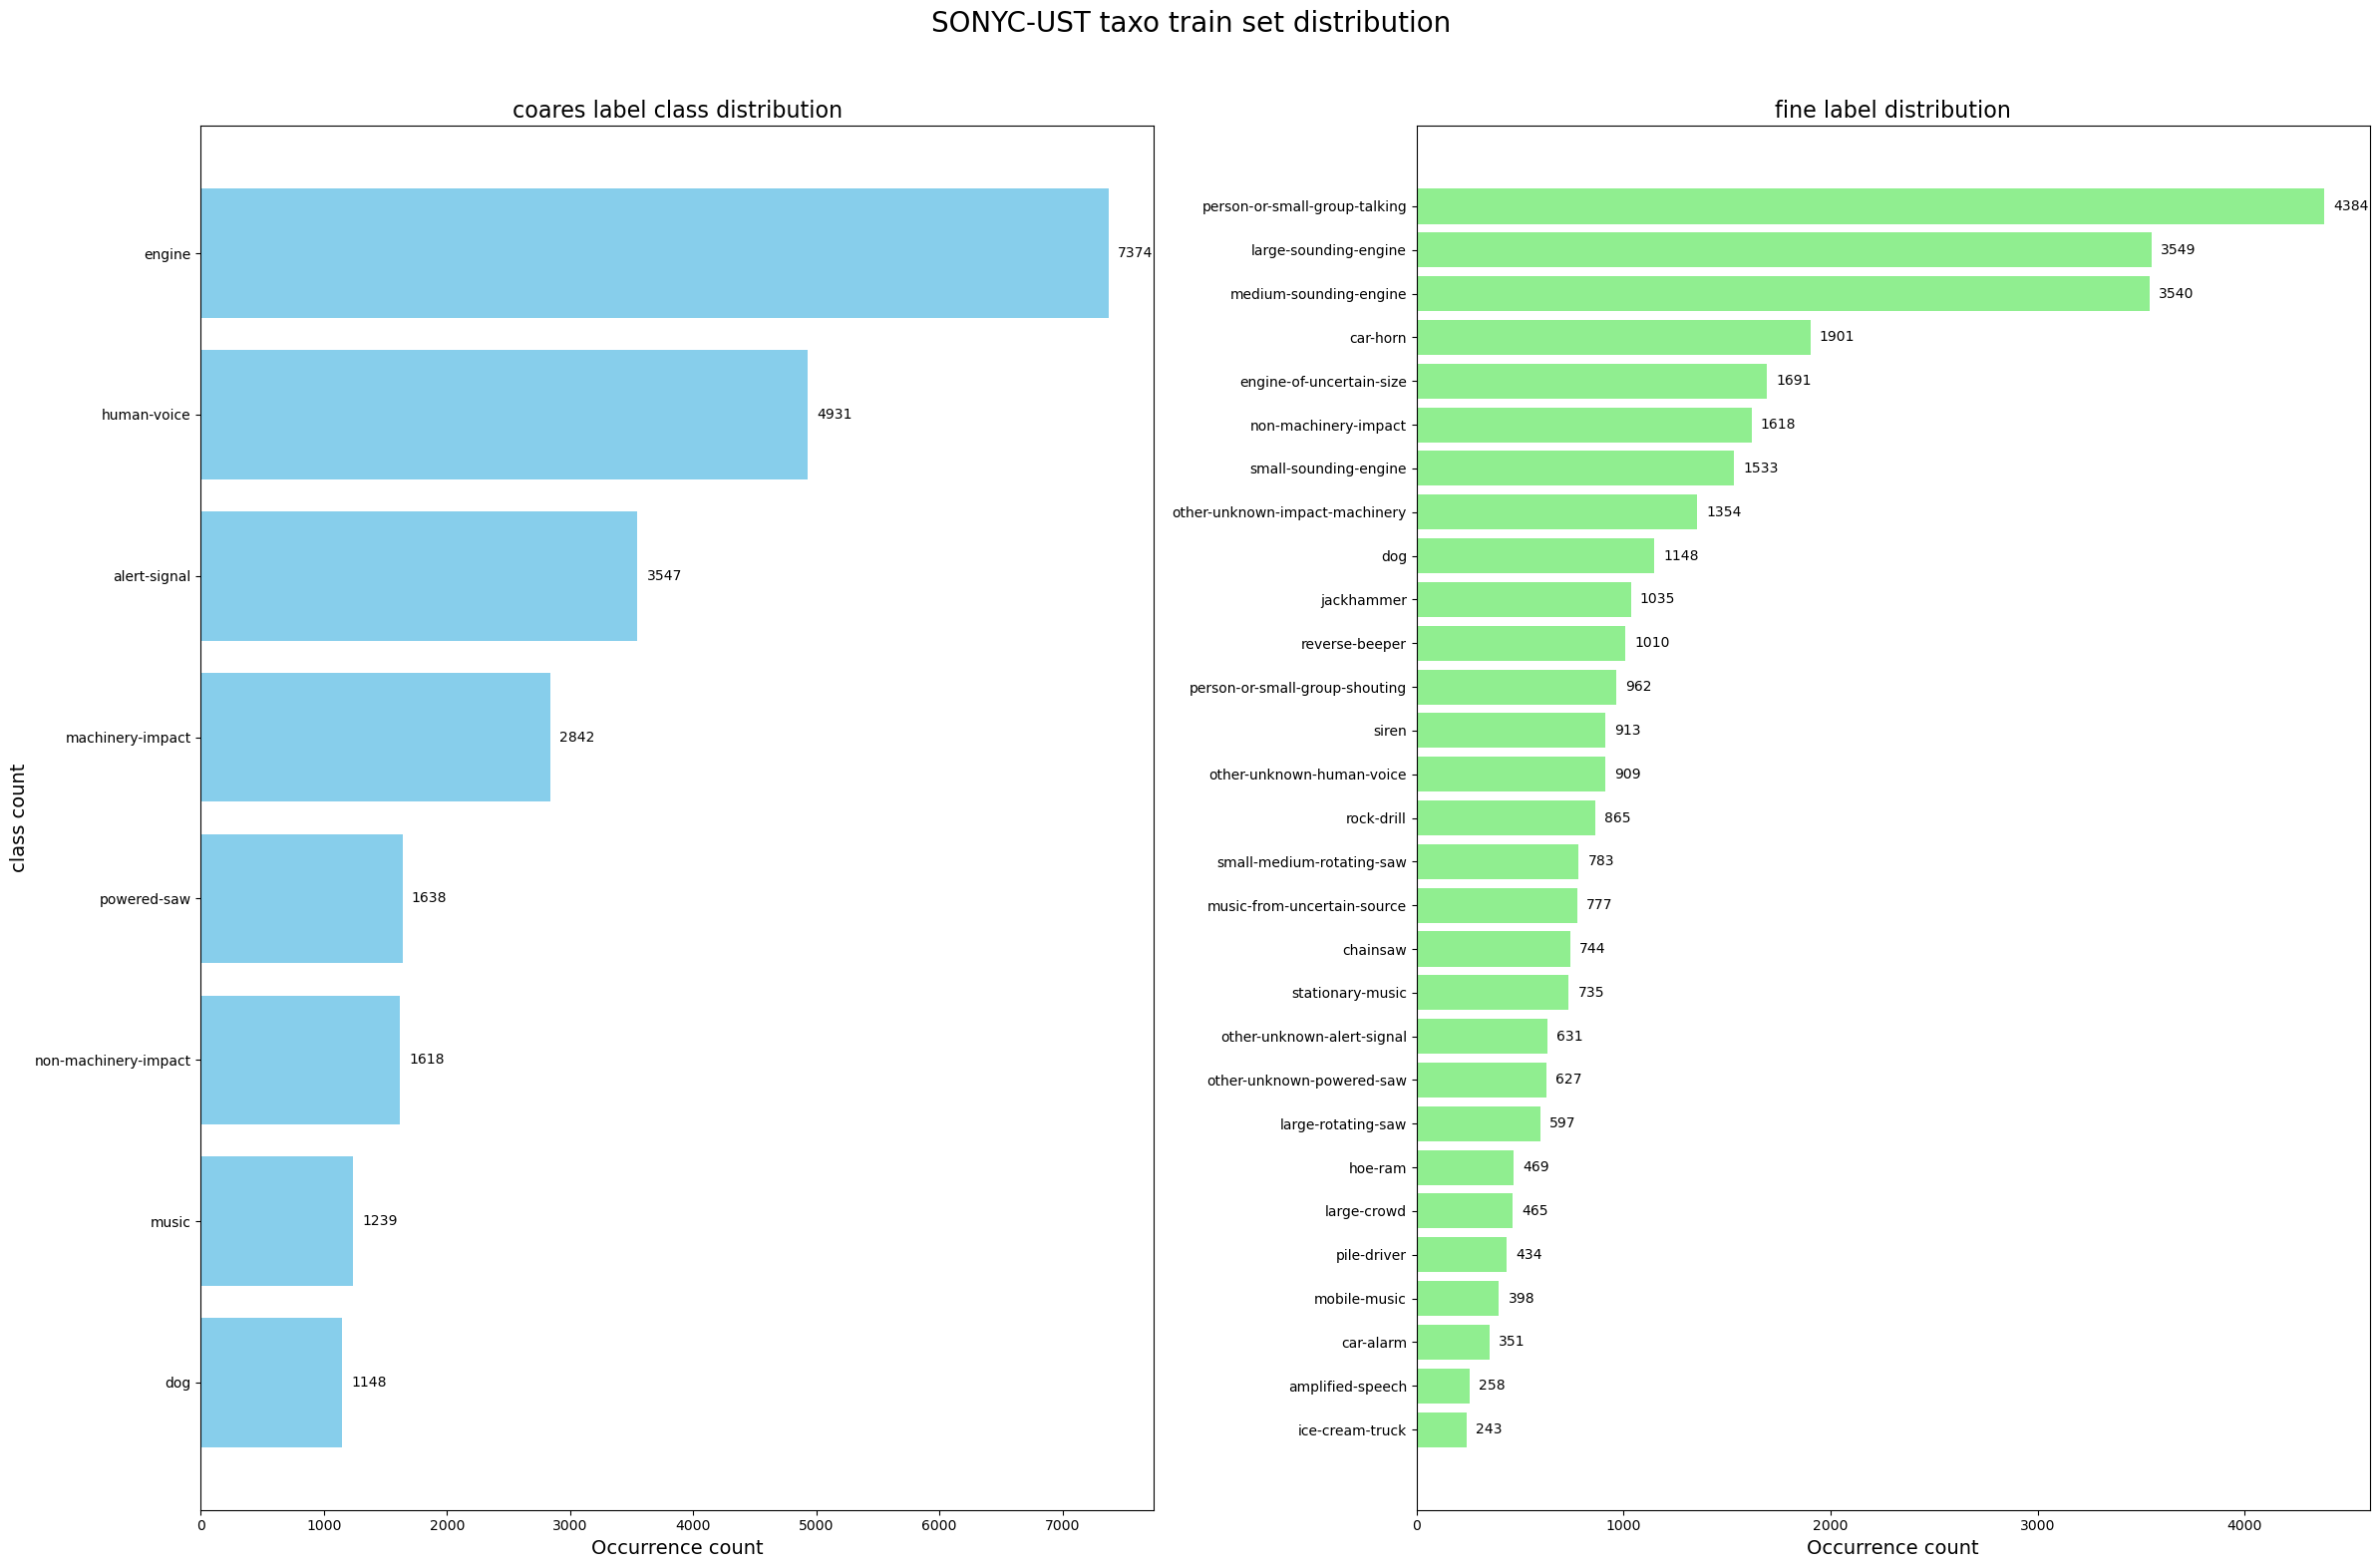

In [11]:
# 读取HDF5文件中的SONYC groundtruth数据
with h5py.File(hdf5_path, 'r') as hf:
    # 确保SONYC组存在
    if 'SONYC' not in hf or 'groundtruth' not in hf['SONYC']:
        raise ValueError("HDF5文件缺少SONYC/groundtruth组")
    
    # 获取粗粒度标签
    coarse_labels = hf['/SONYC/groundtruth/taxonomy_coarse_SONYC'][:]
    coarse_counts = np.sum(coarse_labels, axis=0)
    
    # 获取细粒度标签
    fine_labels = hf['/SONYC/groundtruth/taxonomy_fine_SONYC'][:]
    fine_counts = np.sum(fine_labels, axis=0)
    
    # 获取文件名列表
    filenames = [os.path.splitext(f.decode())[0] 
                 for f in hf['SONYC/filenames'][:]] if 'SONYC/filenames' in hf else []

# 创建统计字典
coarse_count_dict = {label: int(count) 
                     for label, count in zip(coarse_encoder.labels, coarse_counts)
                     if count > 0 and label != "no-annotation"}

fine_count_dict = {label: int(count) 
                   for label, count in zip(fine_encoder.labels, fine_counts)
                   if count > 0 and label != "no-annotation"}

# 按出现次数排序
sorted_coarse = dict(sorted(coarse_count_dict.items(), 
                           key=lambda item: item[1], 
                           reverse=True))

sorted_fine = dict(sorted(fine_count_dict.items(), 
                         key=lambda item: item[1], 
                         reverse=True))

# 创建双子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 16), sharey=False)

# 设置全局标题
fig.suptitle('SONYC-UST taxo train set distribution', fontsize=20)

# 粗粒度类别分布
ax1.barh(
    list(sorted_coarse.keys()), 
    list(sorted_coarse.values()),
    color='skyblue'
)
ax1.set_title('coares label class distribution', fontsize=16)
ax1.set_xlabel('Occurrence count', fontsize=14)
ax1.set_ylabel('class count', fontsize=14)
ax1.invert_yaxis()  # 反转Y轴使最高值在顶部

# 添加数据标签
for i, (label, count) in enumerate(sorted_coarse.items()):
    ax1.text(count + max(sorted_coarse.values())*0.01, 
             i, 
             f'{count}', 
             ha='left', va='center',
             fontsize=10)

# 细粒度类别分布
ax2.barh(
    list(sorted_fine.keys()), 
    list(sorted_fine.values()),
    color='lightgreen'
)
ax2.set_title('fine label distribution', fontsize=16)
ax2.set_xlabel('Occurrence count', fontsize=14)
ax2.invert_yaxis()  # 反转Y轴使最高值在顶部

# 添加数据标签
for i, (label, count) in enumerate(sorted_fine.items()):
    ax2.text(count + max(sorted_fine.values())*0.01, 
             i, 
             f'{count}', 
             ha='left', va='center',
             fontsize=10)

# 调整布局
plt.tight_layout(rect=[0, 0, 1, 0.96])  # 为全局标题留出空间

# 保存图表
plt.savefig('sonyc_event_distribution_subplots.png', dpi=300, bbox_inches='tight')
print("已保存图表: sonyc_event_distribution_subplots.png")

# 显示图表
plt.show()

In [10]:
singa_pura_dataset = SINGAPURA_train_set

已保存图表: singapura_duration_distribution.png


<Figure size 1400x1000 with 0 Axes>

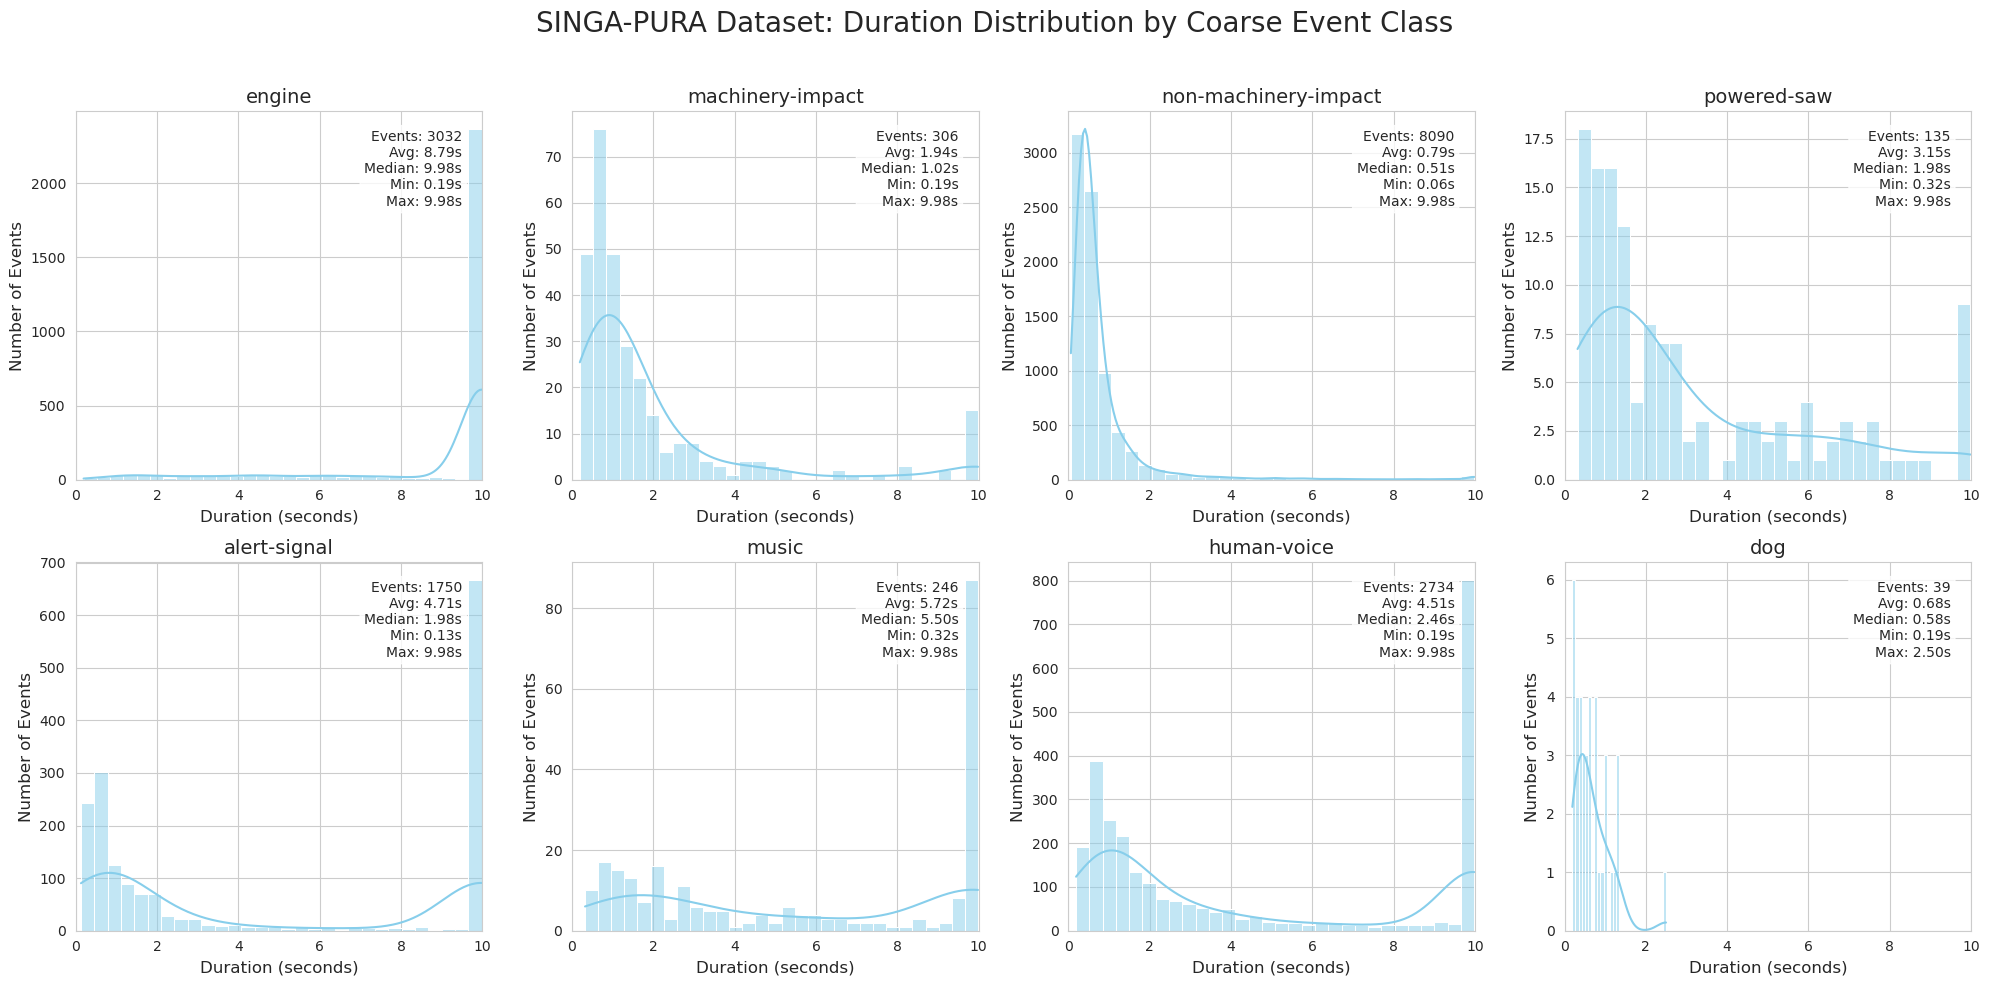

/tmp/ipykernel_6682/372883709.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({
/tmp/ipykernel_6682/372883709.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({
/tmp/ipykernel_6682/372883709.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({
/tmp/ipykernel_6682/372883709.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({
/tmp/ipykernel_6682/372883709.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sum

已保存事件数量分布图: singapura_event_count_distribution.png


/tmp/ipykernel_6682/372883709.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


已保存总持续时间分布图: singapura_total_duration_distribution.png


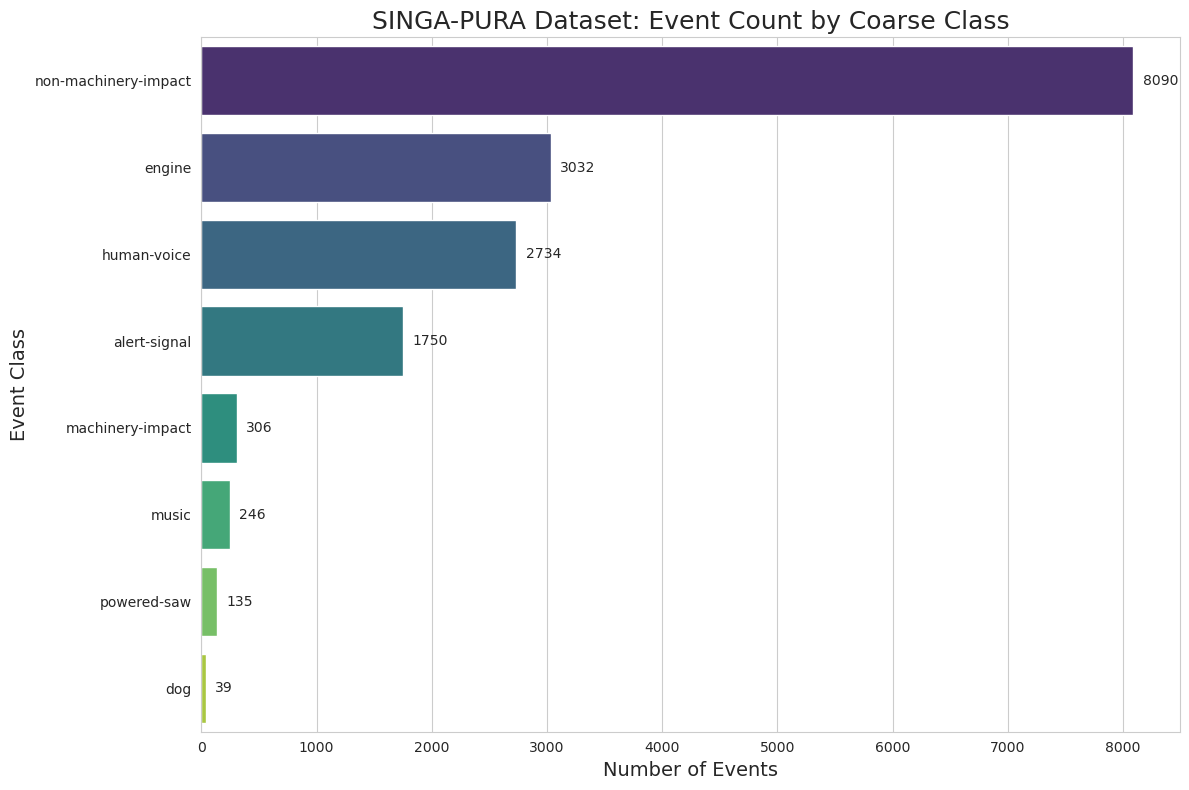

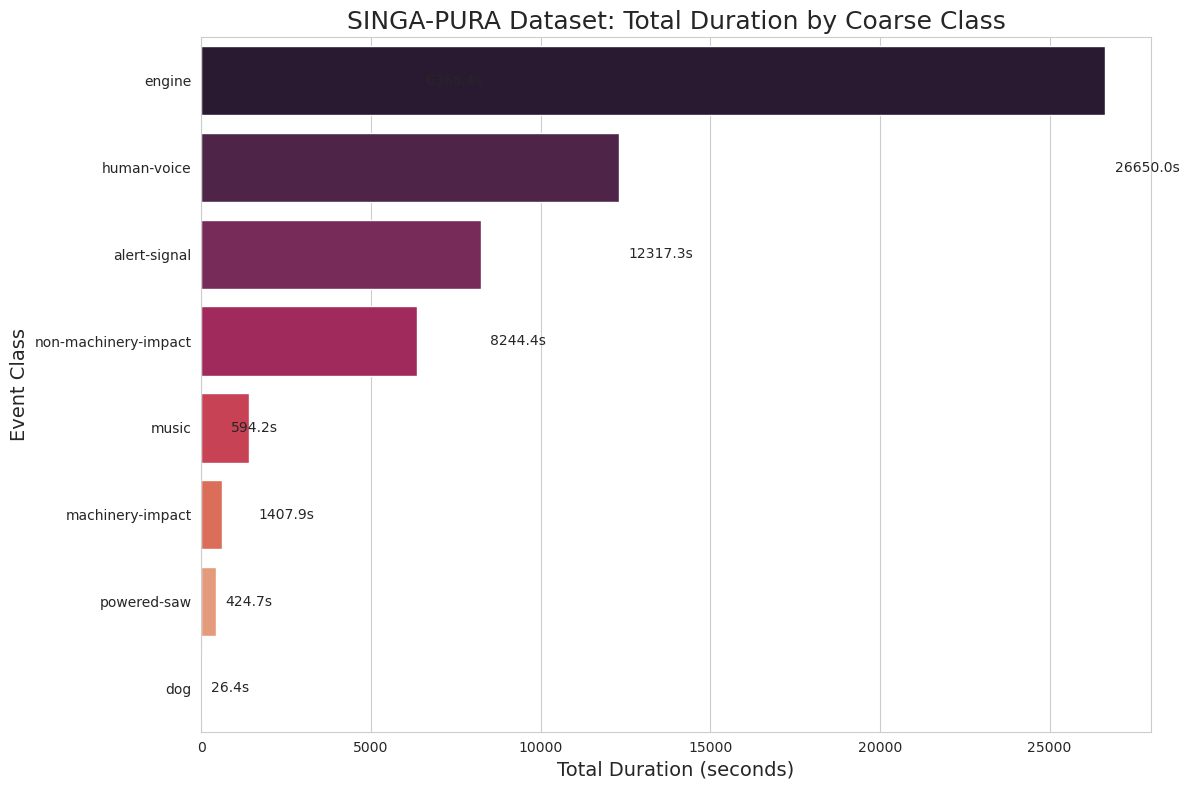

In [11]:
# 获取所有事件数据
all_events = singa_pura_dataset.groundtruths

# 计算持续时间
all_events['duration'] = all_events['offset'] - all_events['onset']

# 设置绘图样式
sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))

# 按类别分组
class_labels = coarse_encoder.labels
n_classes = len(class_labels)

# 创建子图网格
n_cols = 4
n_rows = (n_classes + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()  # 展平轴数组以便迭代

# 为每个类别创建分布图
for i, class_label in enumerate(class_labels):
    ax = axes[i]
    
    # 过滤当前类别的事件
    class_events = all_events[all_events['event_label'] == class_label]
    
    # 跳过没有事件的类别
    if len(class_events) == 0:
        ax.set_title(f"{class_label}\n(0 events)")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(0.5, 0.5, "No events", 
                ha='center', va='center', fontsize=12)
        continue
    
    # 绘制直方图
    sns.histplot(
        class_events['duration'], 
        bins=30, 
        kde=True,
        ax=ax,
        color='skyblue',
        edgecolor='white'
    )
    
    # 添加统计信息
    mean_dur = class_events['duration'].mean()
    median_dur = class_events['duration'].median()
    max_dur = class_events['duration'].max()
    min_dur = class_events['duration'].min()
    
    # 添加统计信息文本
    stats_text = (
        f"Events: {len(class_events)}\n"
        f"Avg: {mean_dur:.2f}s\n"
        f"Median: {median_dur:.2f}s\n"
        f"Min: {min_dur:.2f}s\n"
        f"Max: {max_dur:.2f}s"
    )
    
    ax.text(
        0.95, 0.95, stats_text,
        transform=ax.transAxes,
        ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
        fontsize=10
    )
    
    # 设置标题和标签
    ax.set_title(f"{class_label}", fontsize=14)
    ax.set_xlabel('Duration (seconds)', fontsize=12)
    ax.set_ylabel('Number of Events', fontsize=12)
    ax.set_xlim(0, 10)  # 最大持续时间不超过10秒

# 隐藏多余的子图
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# 添加整体标题
plt.suptitle('SINGA-PURA Dataset: Duration Distribution by Coarse Event Class', 
             fontsize=20, y=0.98)

# 调整布局
plt.tight_layout(rect=[0, 0, 1, 0.96])  # 为全局标题留出空间

# 保存图表
plt.savefig('singapura_duration_distribution.png', dpi=300, bbox_inches='tight')
print("已保存图表: singapura_duration_distribution.png")

# 显示图表
plt.show()

# 创建汇总数据框
summary_df = pd.DataFrame(columns=[
    'Class', 'Total Events', 'Avg Duration', 'Median Duration', 
    'Min Duration', 'Max Duration', 'Total Duration'
])

# 计算每个类别的汇总统计信息
for class_label in class_labels:
    class_events = all_events[all_events['event_label'] == class_label]
    
    if len(class_events) > 0:
        summary_df = summary_df.append({
            'Class': class_label,
            'Total Events': len(class_events),
            'Avg Duration': class_events['duration'].mean(),
            'Median Duration': class_events['duration'].median(),
            'Min Duration': class_events['duration'].min(),
            'Max Duration': class_events['duration'].max(),
            'Total Duration': class_events['duration'].sum()
        }, ignore_index=True)

# 按总事件数排序
summary_df = summary_df.sort_values('Total Events', ascending=False)

# # 保存汇总统计信息
# summary_df.to_csv('singapura_event_duration_summary.csv', index=False)
# print("已保存汇总统计数据: singapura_event_duration_summary.csv")

# 绘制事件数量分布图
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x='Total Events', 
    y='Class', 
    data=summary_df,
    palette='viridis',
    order=summary_df.sort_values('Total Events', ascending=False)['Class']
)

# 添加数据标签
for i, value in enumerate(summary_df['Total Events']):
    ax.text(value + max(summary_df['Total Events'])*0.01, 
            i, 
            f'{int(value)}', 
            ha='left', va='center',
            fontsize=10)

plt.title('SINGA-PURA Dataset: Event Count by Coarse Class', fontsize=18)
plt.xlabel('Number of Events', fontsize=14)
plt.ylabel('Event Class', fontsize=14)
plt.tight_layout()
plt.savefig('singapura_event_count_distribution.png', dpi=300, bbox_inches='tight')
print("已保存事件数量分布图: singapura_event_count_distribution.png")

# 绘制总持续时间分布图
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x='Total Duration', 
    y='Class', 
    data=summary_df,
    palette='rocket',
    order=summary_df.sort_values('Total Duration', ascending=False)['Class']
)

# 添加数据标签
for i, value in enumerate(summary_df['Total Duration']):
    ax.text(value + max(summary_df['Total Duration'])*0.01, 
            i, 
            f'{value:.1f}s', 
            ha='left', va='center',
            fontsize=10)

plt.title('SINGA-PURA Dataset: Total Duration by Coarse Class', fontsize=18)
plt.xlabel('Total Duration (seconds)', fontsize=14)
plt.ylabel('Event Class', fontsize=14)
plt.tight_layout()
plt.savefig('singapura_total_duration_distribution.png', dpi=300, bbox_inches='tight')
print("已保存总持续时间分布图: singapura_total_duration_distribution.png")

# Export Model

In [9]:
print(torch.__version__, pl.__version__)

2.0.1 1.5.1


In [10]:
path_ckpt = "../experiments/COSMO/[8, 16, 24]_[09, 01, 0]_log_baseline_SONYC_strong/version_3/epoch=85-step=45493.ckpt"
path_hparam = path_ckpt = "../experiments/COSMO/[8, 16, 24]_[09, 01, 0]_log_baseline_SONYC_strong/version_3/hparams.yaml"
with open(path_hparam, "r") as h:
    conf_net = yaml.safe_load(h)

In [11]:
conf_net["net"].update({"n_class": len(encoder.labels)})
conf_net.update({"taxonomy": encoder.taxonomy["name"]})
print(encoder.taxonomy["name"])
print(len(encoder.labels))

taxonomy_coarse_SONYC
8


In [ ]:
sed_student = CRNN.CRNN(**conf["net"])
print(sed_student.parameters())
model = CoSMo_benchmark.load_from_checkpoint(
    path_ckpt, encoder=encoder_coarse_sn, sed_student=sed_student, hparams=conf_net
)

<generator object Module.parameters at 0x7efce56e0890>


UnpicklingError: could not find MARK